Useless for now since all the simulations converged

In [16]:
import os
import numpy as np
import pandas as pd
import sys

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.getcwd()))
from tools.utils import encode_all_structures, Encoding

In [17]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [18]:
encoding = Encoding.COLUMN_MASS

df = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), index_col=0, na_filter= False)
df = encode_all_structures(df, encoding)

In [19]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'delta_E', 'accuracy', "n_iterations", "time", "fermi", "total_energy"]
cols_independent = ['converged']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [20]:
X_raw = df[cols_dependent]
y_raw = np.abs(df[cols_independent]).squeeze()

In [21]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,Lant,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,...,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.0
mean,244.850734,5.839848,58.411977,0.149177,0.031173,0.043240,0.022388,0.023752,0.031421,0.015835,...,0.054770,0.056758,0.062610,0.037938,0.046023,0.049814,0.091317,0.060502,0.024574,0.0
std,89.258136,2.830937,24.136707,0.287443,0.133047,0.133163,0.107280,0.107936,0.123172,0.094961,...,0.183287,0.190763,0.188731,0.146247,0.161086,0.138497,0.206135,0.166459,0.127998,0.0
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,0.924714,0.733997,0.732088,0.741626,0.841555,0.885522,0.783026,...,0.876908,0.983118,0.899810,0.803422,0.967155,0.808676,0.918451,0.839999,0.833172,0.0


# Train-Test-Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Random forest

In [23]:
rf_model = RandomForestClassifier(random_state=0)

### Gradient Boosting

In [24]:
gb_model = GradientBoostingClassifier(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [25]:
xgb_model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [26]:
models = {
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [27]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [28]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # classification accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # f1 score
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"Accuracy:\ttrain:{train_acc}\ttest:{test_acc}")
    print(f"F1 score:\ttrain:{train_f1}\ttest:{test_f1}")

    print("Done!\n")

Evaluating Random Forest...
Accuracy:	train:1.0	test:1.0
F1 score:	train:1.0	test:1.0
Done!

Evaluating XGBoost...
Accuracy:	train:1.0	test:1.0
F1 score:	train:1.0	test:1.0
Done!



# Visualization

Text(0.5, 0, 'ecutwfc')

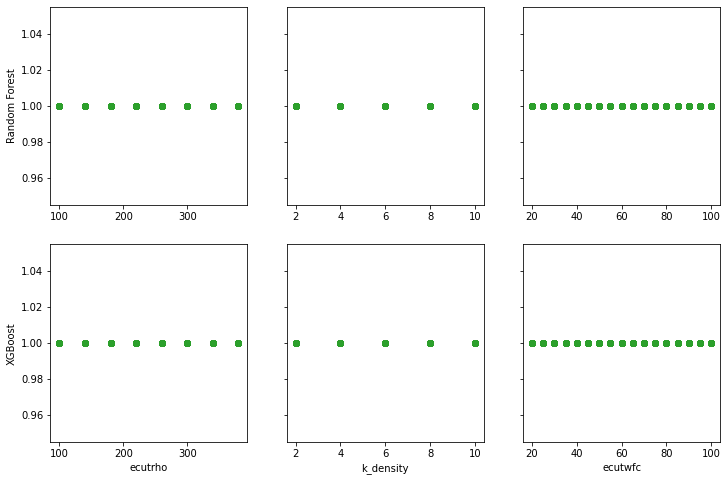

In [29]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

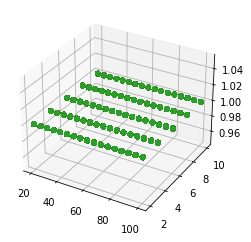

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))